## Importing necessary libraries


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os

In [2]:
df_train = pd.read_csv('Dataset/Fall/train_labels.csv', index_col='images')
df_train

,labels
images,
fall-02-cam1-rgb-001.jpg,0
fall-02-cam1-rgb-002.jpg,0
fall-02-cam1-rgb-003.jpg,0
fall-02-cam1-rgb-004.jpg,0
fall-02-cam1-rgb-005.jpg,0
...,...
fall-11-cam1-rgb-126.jpg,1
fall-11-cam1-rgb-127.jpg,1
fall-11-cam1-rgb-128.jpg,1


In [3]:
test_df = pd.read_csv('Dataset/Fall/test_labels.csv', index_col='images')
test_df

,labels
images,
fall-03-cam1-rgb-077.jpg,0
fall-03-cam1-rgb-093.jpg,0
fall-03-cam1-rgb-178.jpg,1
fall-03-cam1-rgb-196.jpg,1
fall-04-cam1-rgb-005.jpg,0
fall-04-cam1-rgb-042.jpg,1
fall-04-cam1-rgb-057.jpg,1
fall-17-cam1-rgb-068.jpg,1
fall-17-cam1-rgb-094.jpg,1


In [4]:
# 0 mean not Fall and 1 mean  fall

In [5]:
# reading train and test images from the folder and stacking them while keep tracking of corresponding labels
dataset_folder = 'Dataset/Fall'
train_images = []
train_labels = []
test_images = []
test_labels = []

for folder in os.listdir(dataset_folder):
    folder_path = os.path.join(dataset_folder, folder)
    if folder == 'train_images':
        for file in os.listdir(folder_path):
            if file.endswith('jpg'):
                img_path = os.path.join(folder_path, file)
                img = cv2.imread(img_path)
                train_images.append(img)
                train_labels.append(df_train.loc[file, 'labels'])
    
    elif folder == 'test_images':
        for file in os.listdir(folder_path):
            if file.endswith('jpg'):
                img_path = os.path.join(folder_path, file)
                img = cv2.imread(img_path)
                test_images.append(img)
                test_labels.append(test_df.loc[file, 'labels'])
    else:
        pass
            
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)
print('Shape of stacked train images:', train_images.shape)
print('Shape of train labels:', train_labels.shape)
print('Shape of stacked test images:', test_images.shape)
print('Shape of test labels:', test_labels.shape)

Shape of stacked train images: (240, 96, 96, 3)
Shape of train labels: (240,)
Shape of stacked test images: (12, 96, 96, 3)
Shape of test labels: (12,)


In [6]:
# Function to convert binary label into text
def get_label(num):
    if num == 0:
        return 'NOT FALL'
    if num == 1:
        return 'FALL'
    else:
        return -1

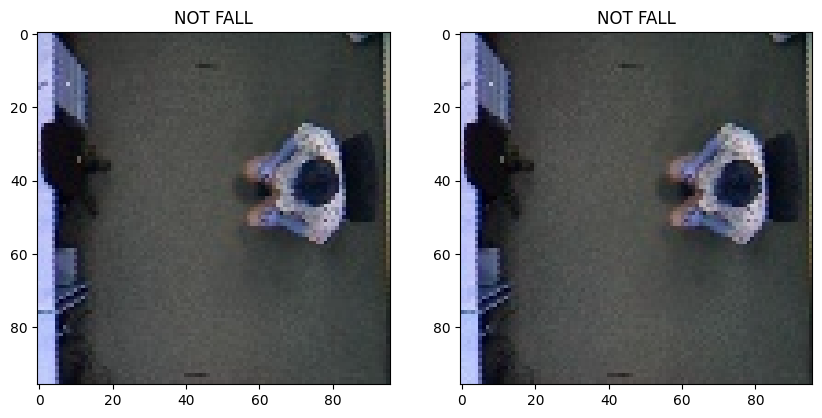

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 8), squeeze=False)
axes[0][0].imshow(train_images[2])
axes[0][0].set_title(get_label(train_labels[2]))

axes[0][1].imshow(train_images[3])
axes[0][1].set_title(get_label(train_labels[3]));

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, stratify=train_labels, test_size=0.2)

In [9]:
X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255

In [10]:
w, h = 96 , 96 
X_train = X_train.reshape(X_train.shape[0],w,h,3)
X_ = X_val.reshape(X_val.shape[0],w,h,3)

In [11]:
import cv2
import numpy as np
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
import numpy as np
import tensorflow as tf

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os


NUM_CLASSES = 1
IMG_SIZE = 96

In [12]:
optimizer = tf.keras.optimizers.Adam(lr=0.001, epsilon=1e-08, decay=0.0)
import keras.backend as K
import tensorflow as tf
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())
def conditional_average_metric(y_true, y_pred):
    spec = specificity(y_true, y_pred)
    sens = sensitivity(y_true, y_pred)

    minimum = K.minimum(spec, sens)
    condition = K.less(minimum, 0.5)

    multiplier = 0.001
    # This is the constant used to substantially lower
    # the final value of the metric and it can be set to any value
    # but it is recommended to be much lower than 0.5

    result_greater = 0.5 * (spec + sens)
    result_lower = multiplier * (spec + sens)
    result = K.switch(condition, result_lower, result_greater)

    return result
def sensitivity(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())
def F1_Score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
metrics=[tf.keras.metrics.AUC(num_thresholds=200,curve='ROC',summation_method='interpolation',name=None,dtype=None,thresholds=None,multi_label=False,num_labels=None,label_weights=None,from_logits=False),
                         tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),'accuracy',
                   specificity,conditional_average_metric ,sensitivity,F1_Score]

C:\Users\haider computer s\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [13]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    #x = img_augmentation(inputs)
    x = inputs
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=metrics
    )
    return model

In [14]:
model = build_model(1)

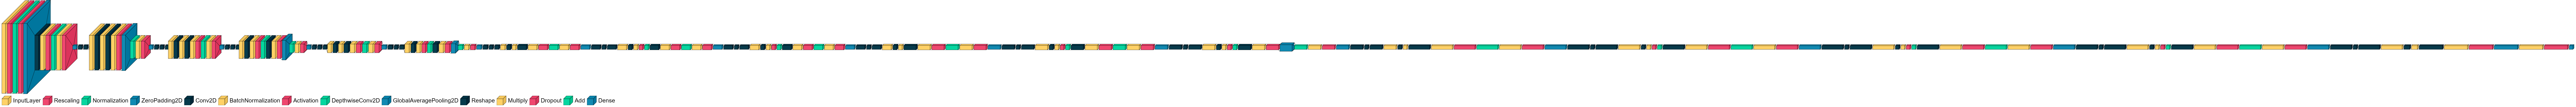

In [15]:
import visualkeras
from PIL import ImageFont

font = ImageFont.truetype("arial.ttf", 32) 
visualkeras.layered_view(model, legend=True, font=font, to_file='fallnet_architecture.png') 

In [16]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='val_accuracy',
    restore_best_weights=True,
    verbose=1
)
from livelossplot.inputs.keras import PlotLossesCallback
from keras.callbacks import ModelCheckpoint
plot_loss_1 = PlotLossesCallback()

#ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='model.h5',
                                  save_best_only=True,
                                  verbose=1)

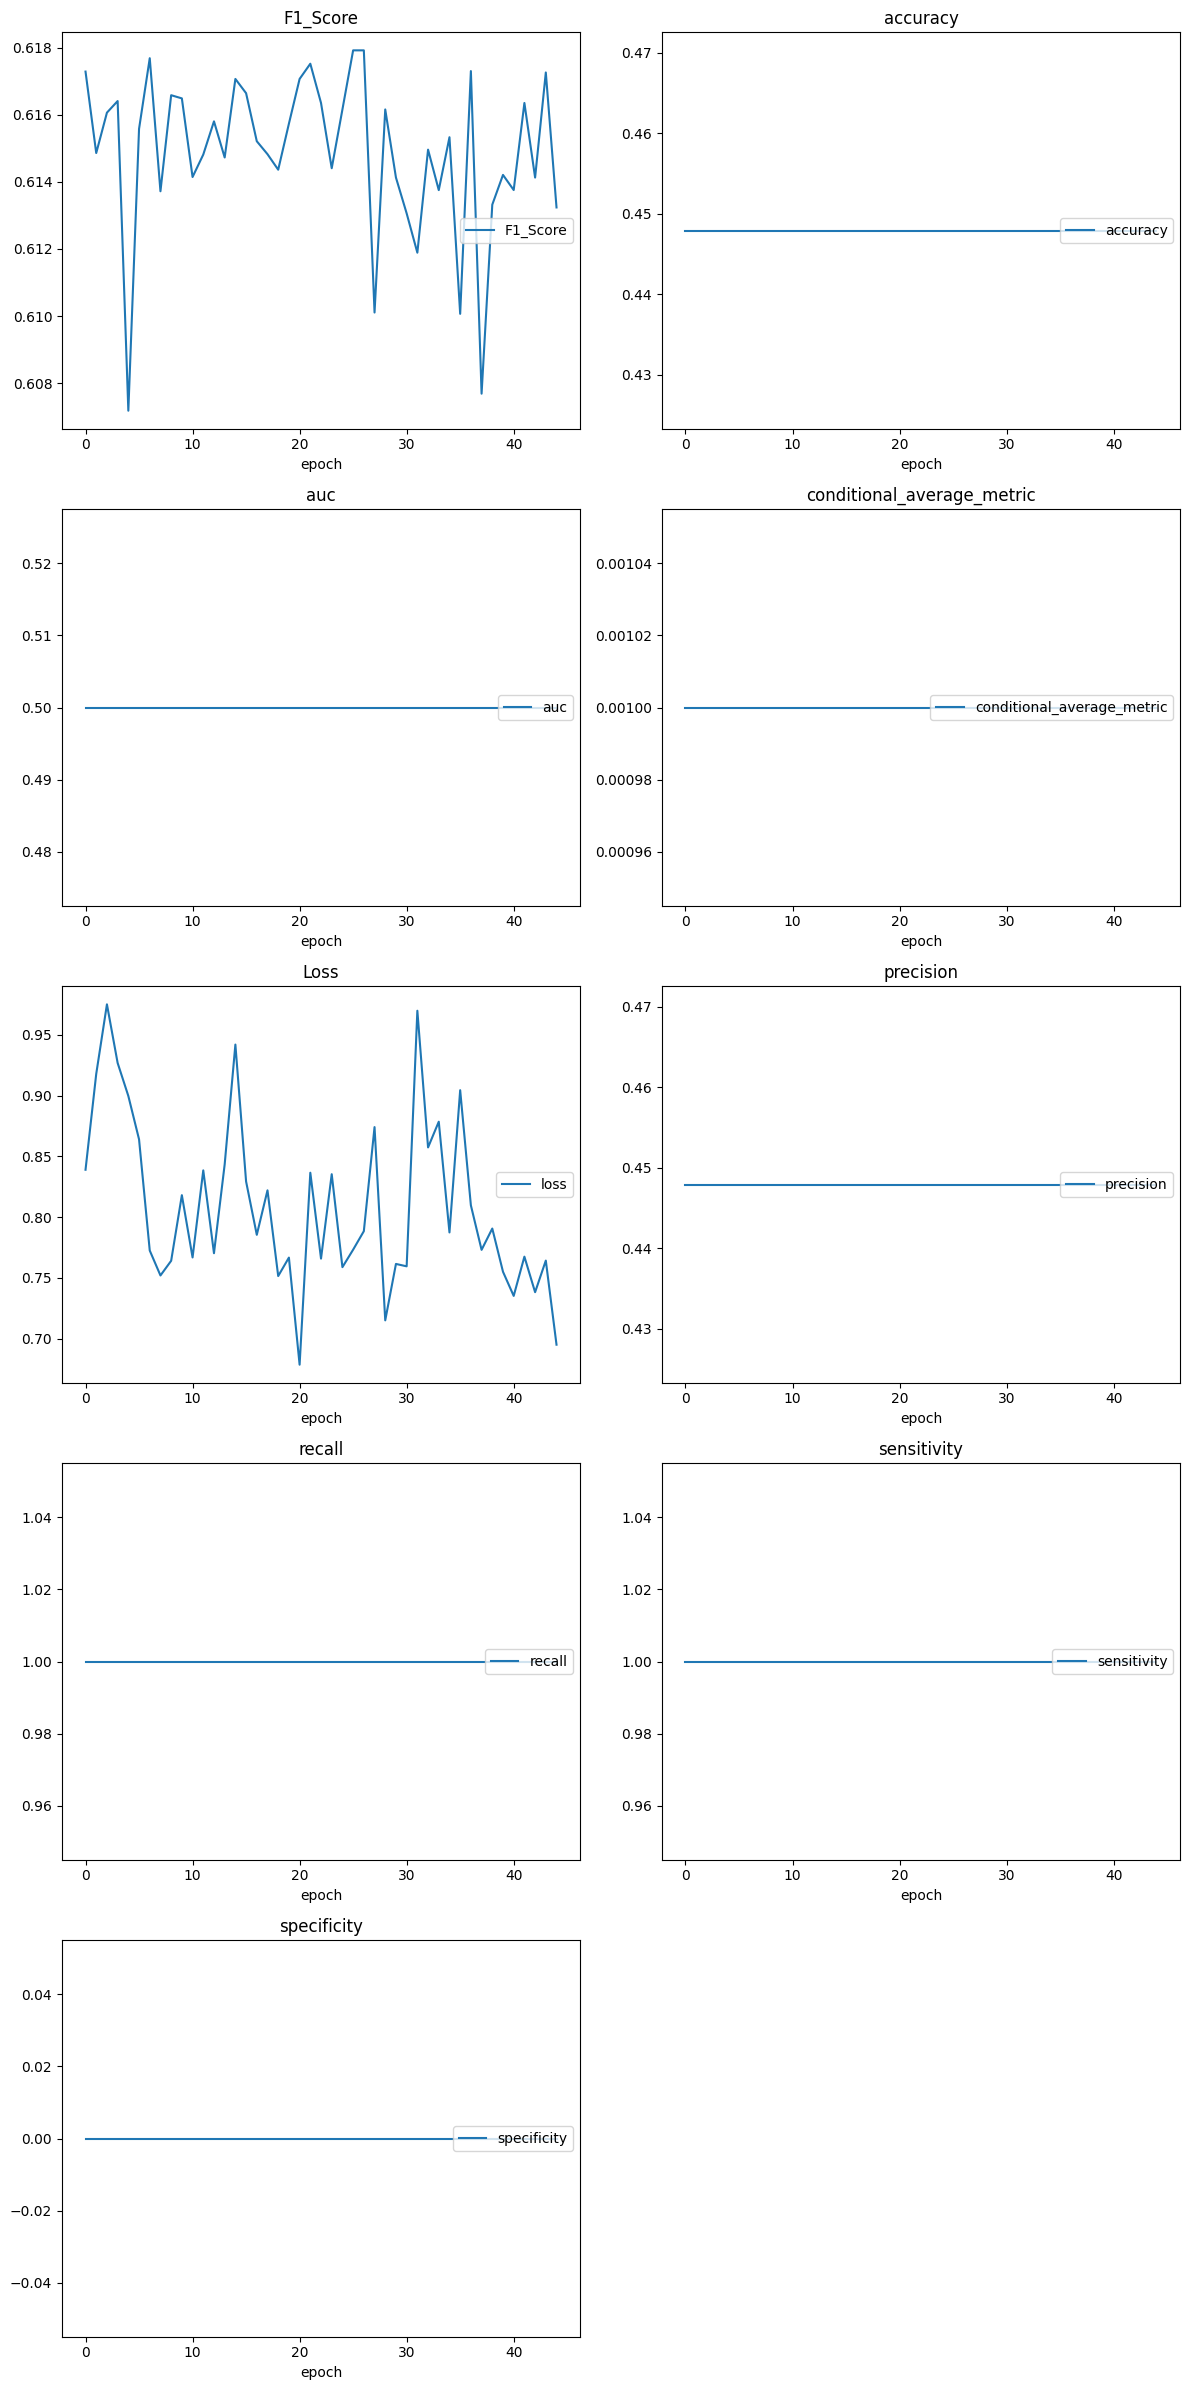

F1_Score
	F1_Score         	 (min:    0.607, max:    0.618, cur:    0.613)
accuracy
	accuracy         	 (min:    0.448, max:    0.448, cur:    0.448)
auc
	auc              	 (min:    0.500, max:    0.500, cur:    0.500)
conditional_average_metric
	conditional_average_metric 	 (min:    0.001, max:    0.001, cur:    0.001)
Loss
	loss             	 (min:    0.679, max:    0.975, cur:    0.695)
precision
	precision        	 (min:    0.448, max:    0.448, cur:    0.448)
recall
	recall           	 (min:    1.000, max:    1.000, cur:    1.000)
sensitivity
	sensitivity      	 (min:    1.000, max:    1.000, cur:    1.000)
specificity
	specificity      	 (min:    0.000, max:    0.000, cur:    0.000)
6/6 - 5s - loss: 0.6951 - auc: 0.5000 - precision: 0.4479 - recall: 1.0000 - accuracy: 0.4479 - specificity: 0.0000e+00 - conditional_average_metric: 0.0010 - sensitivity: 1.0000 - F1_Score: 0.6132 - 5s/epoch - 812ms/step
Epoch 46/100


In [ ]:
epochs = 100 
hist = model.fit(X_train, y_train, epochs=epochs, verbose=2,callbacks=[
        early_stopping_callback,plot_loss_1,tl_checkpoint_1
    ])